In [1]:
# python으로 사용할 라이브러리들 import
import numpy as np # numpy
import cv2  # opencv2
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
# 이미지의 크기를 확인
from PIL import Image
# 파일명 가져오기위해 import
import os

In [2]:
# 이미지 크기를 확인하고 yolo의 바운더링 박스 위치를 실좌표로 변환하여 
# yolo로 탐지된 이미지에서 탐지된 객체만 잘라 새로운 이미지로 저장하는 코드
# 사각 영역 지정을 위한 사진
imagePath = 'C:\\vsCode\PillProject\yolov5ResultFile\pill49\pill49.jpg'
txtPath =  "C:\\vsCode\PillProject\yolov5ResultFile\pill49\labels\pill49.txt"
image1 = Image.open(imagePath)

width,height = image1.size
print(width,height)

1299 709


In [3]:
# 바운더링 박스 좌표 읽기.
f = open(txtPath, 'r')
line = f.readline()
# 공백을 기준으로 자르기
space = line.split()

x = float(space[1]) 
y = float(space[2]) 
w = float(space[3]) 
h = float(space[4]) 

img_w = width            # 이미지 가로
img_h = height           # 이미지 세로

dw = 1./img_w
dh = 1./img_h

x = x/dw
y = y/dh
w = round(w/dw)                 # Box 가로
h = round(h/dh)                 # Box 세로

x1 = round((2*x - w)/2)         # 좌측 최상단 x좌표
y1 = round((2*y - h)/2)         # 좌측 최상단 y좌표

print(str(x1) + ' ' + str(y1) + ' ' + str(w) + ' ' + str(h))

image1.show()

247 233 286 164


In [4]:
# 이미지 자르기 crop함수 이용 ex. crop(left,up, rigth, down)
croppedImage=image1.crop((x1,y1,x1 + w, y1 + h))

print("잘려진 사진 크기 :",croppedImage.size)

file_path = os.path.splitext(imagePath)[0]
pillPathSpile = file_path.split('/')[-1]
pillName = 'croppedImage1.jpg'

croppedImage.save(pillPathSpile + pillName)

folder_path = ''
for i in file_path.split('/')[0:-1]:
  folder_path = folder_path + i + "/"
print(folder_path)


잘려진 사진 크기 : (286, 164)



In [5]:
imagePath = folder_path + pillPathSpile + pillName

origin_image = cv2.imread(imagePath)
hsv_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2HSV)

val = 100
array = np.full(hsv_image.shape, (0,0,val), dtype=np.uint8)

val_add_image = cv2.add(hsv_image, array)

print('BGR : \t',origin_image[55,116,:])
print('hsv : \t',hsv_image[55,116,:])
print('hsv 밝기(v) 증가 : \t',val_add_image[55,116,:])

# hsv방식으로 밝기를 증가시킨 뒤 다시 rgb방식으로 변환.
# cv2_imshow를 한번에 보여주기위해 합친 것
# val_add_image가 수정된 이미지
val_add_image = cv2.cvtColor(val_add_image, cv2.COLOR_HSV2BGR)
image = np.concatenate((origin_image,val_add_image), axis=1)

cv2.imshow('',image)
cv2.waitKey(0)

# 기존 색깔들을 밝기를 최대로 증가시켰을 때 변화가 없음.
# 이건 다양한 색깔의 알약들의 image들을 hsv방식으로 변환시켜 밝기를 최대로 증가시킨뒤
# rgb방식으로 다시 변환하여 색깔을 판단하는 기준으로 사용할 수 있을지도 모르겠음.

pillName = 'croppedImage2.jpg'

# 변환된 이미지 저장.
cv2.imwrite(folder_path + pillPathSpile + pillName, val_add_image)

BGR : 	 [206 163 112]
hsv : 	 [104 116 206]
hsv 밝기(v) 증가 : 	 [104 116 255]


True

In [6]:
# 이미지 클러스터링

img = cv2.imread(folder_path + pillPathSpile + pillName)
# img = cv2.resize(img,(480,480))
z = img.reshape((-1,3))

z = np.float32(z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
k3 = 3
k6 = 6
k9 = 9

# 클러스터링을 3,6,9로 하였을 때 비교 하기위해서 3,6,9모두 
ret3, label3, center3 = cv2.kmeans(z,k3,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
ret6, label6, center6 = cv2.kmeans(z,k6,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
ret9, label9, center9 = cv2.kmeans(z,k9,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

center3 = np.uint8(center3)
res3 = center3[label3.flatten()]
res3 = res3.reshape(img.shape)

center6 = np.uint8(center6)
res6 = center6[label6.flatten()]
res6 = res6.reshape(img.shape)

center9 = np.uint8(center9)
res9 = center9[label9.flatten()]
res9 = res9.reshape(img.shape)

# 원본이미지와 클러스터링 이미지들 출력
cv2.imshow('원본이미지',img)
cv2.imshow('3가지 클러스터링 이미지',res3)
# cv2_imshow(res6)
# cv2_imshow(res9)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
# k의 값이 증가하며 색의 구별이 더 잘되는것이 확인가능하다.
# 색상양자화 -> 이미지에서 색상 수를 줄이는 처리를 의미한다.
# 해당 처리를 하는 보편적인 이유는 메모리를 줄여 연산 속도를 빠르게 하기 위함이지만
# 알약이 어떤 색상인지 판단하는데에는 
# opencv에서는 RGB순서가 아닌 BGR순서로 리턴되므로 RGB순서로 바꾸어주어야한다.
# 채널을 BGR -> RGB로 변경
image = cv2.cvtColor(res3, cv2.COLOR_BGR2RGB)

# 차원이 분산되어있어 수치적 계산을 하기 어려우니 width, height를 한개의 array로 통합
image = image.reshape((image.shape[0] * image.shape[1], 3)) # height, width 통합
# print(image.shape)

# scikit-learn의 k-mean 알고리즘으로 이미지를 학습
k = 3 
clt = KMeans(n_clusters = k)
clt.fit(image)

for center in clt.cluster_centers_:
    print(center)

def centroid_histogram(clt):
    # 서로 다른 군집 수를 잡고 히스토그램을 만들기
    # 각 클러스터에 할당된 픽셀 수를 기준으로 함
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # 합계가 1이 되도록 히스토그램을 정규화
    hist = hist.astype("float")
    hist /= hist.sum()

    # 히스토그램 return
    return hist


hist = centroid_histogram(clt)
print(hist)

[149. 208. 251.]
[244.  76.  84.]
[218. 227. 249.]
[0.60146256 0.047416   0.35112144]


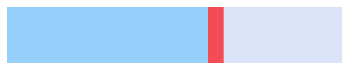

In [8]:
def plot_colors(hist, centroids):
    # 각 색상의 상대 빈도를 나타내는 막대 차트를 초기화
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # 각 클러스터의 백분율과 각 클러스터의 색을 겹칩니다.
    for (percent, color) in zip(hist, centroids):
        # 각 군집의 상대 백분율 표시
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # 바 return
    return bar

bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [11]:
# rgb값으로 색깔 판단하기 

# 1. rgb값 추출하여 정수로 변환하기
rgb_color = clt.cluster_centers_[0]

# r값 추출
r_color = rgb_color[0]
r_color = round(r_color)

# b값 추출
g_color = rgb_color[1]
g_color = round(g_color)

# c값 추출
b_color = rgb_color[2]
b_color = round(b_color)

# rgb값 확인
print("r = {} g = {} b = {}".format(r_color,g_color,b_color))

# 2. 만들어진 기준표로 rgb값의 상한 하한을 확인하여 색깔추출하기
# 하양 노랑 주황 분홍 빨강 갈색 연두 초록 철록 파랑 남색 자주 보라 회색 검정
# 하양  200이상 200이상 200이상
# 노랑 - 주황 210이상 100이하 75이하
# 분홍 - 빨강 - 갈색  210 이상, 100이하, 50 이상 
# 연두 - 초록  100이하 200이상 50이하
# 청록 - 파랑 - 남색  50이하 100이하 210이상
# 자주 - 보라 150상 50이하 210이상
# 회색 - 검정 100이하 100 이하 100이하 

color = ''

# 하양 주황 빨강 파랑 초록구분하기.
if(r_color >= 230):
  if(g_color >= 230):
    if(b_color >= 230):
      color = "하양"
    else:
      color = "색깔을 정확하게 확인할 수 없습니다."
  elif(g_color >= 110):
    if(b_color <= 120):
      color = "주황"
    else:
      color = "색깔을 정확하게 확인할 수 없습니다."
  else:
    if(b_color <= 120):
      color = "빨강"
    else:
      color = "색깔을 정확하게 확인할 수 없습니다."
else:
  if(g_color >= 180):
    if(b_color >= 230):
      color = "파랑"
    else:
      color = "초록"
  else:
    color = "색깔을 정확하게 확인할 수 없습니다."
    
print("color : ",color)


r = 149 g = 208 b = 251
color :  파랑
